In [1]:
import datetime
import math
import pandas as pd

In [2]:
val_seed = 5532
num_darts = [10**2,10**3,10**4,10**5,10**6,10**7]
val_max = max(num_darts)

In [3]:
print('For reference, Python\'s value of pi = '+str(math.pi))

For reference, Python's value of pi = 3.141592653589793


<img src='./MonteCarloApproach.png'>
From UC Berkeley

# Using Numpy

In [4]:
import numpy as np
from operator import add

In [5]:
def get_pi_numpy(val_size,val_max,val_seed=val_seed):
    if(val_size <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        x = np.random.random_sample(size=val_size)
        y = np.random.random_sample(size=val_size)
        x_2 = [i**2 for i in x]
        y_2 = [j**2 for j in y]
        line_len = list(map(add,x_2,y_2))
        less_than_1 = len([1 for i in line_len if i < 1])
        tmp_pi = 4*(less_than_1/val_size)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str(val_size)+' ('+str(100*round(val_size/val_max,5))+'% of total); took '+str(total_s)+' secs.')
    return(pd.Series([tmp_pi,total_s]))

In [6]:
%%time
pi_from_numpy = [get_pi_numpy(val_size=x,val_max=val_max) for x in num_darts]
df_pi_from_numpy = pd.DataFrame(pi_from_numpy)
df_pi_from_numpy.columns=['EstPi','Time']
df_pi_from_numpy['Error'] = math.pi-df_pi_from_numpy['EstPi']
df_pi_from_numpy['SampleSize'] = num_darts
df_pi_from_numpy['Src'] = 'Numpy'

Calc. value pi = 3.16; sample size = 100 (0.001% of total); took 0.000879 secs.
Calc. value pi = 3.164; sample size = 1000 (0.01% of total); took 0.003307 secs.
Calc. value pi = 3.1436; sample size = 10000 (0.1% of total); took 0.017355 secs.
Calc. value pi = 3.1508; sample size = 100000 (1.0% of total); took 0.140146 secs.
Calc. value pi = 3.14234; sample size = 1000000 (10.0% of total); took 1.395011 secs.
Calc. value pi = 3.14151; sample size = 10000000 (100.0% of total); took 15.318113 secs.
CPU times: user 17.7 s, sys: 1.02 s, total: 18.7 s
Wall time: 19.1 s


# Using Pandas

In [7]:
def get_pi_df(val_size,val_max,val_seed=val_seed):
    if(val_size <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        df = pd.DataFrame({'x':np.random.random_sample(size=val_size),'y':np.random.random_sample(size=val_size)})
        df['x_2'] = df['x']**2
        df['y_2'] = df['y']**2
        df['line_len'] = df['x_2']+df['y_2']
        df['less_than_1'] = [1 if x < 1 else 0 for x in df['line_len']]
        tmp_pi = 4*(df['less_than_1'].sum()/val_size)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str(val_size)+' ('+str(100*round(val_size/val_max,5))+'% of total); took '+str(total_s)+' secs.')
    return(pd.Series([tmp_pi,total_s]))

In [8]:
%%time
pi_from_df = [get_pi_df(val_size=x,val_max=val_max) for x in num_darts]
df_pi_from_df = pd.DataFrame(pi_from_df)
df_pi_from_df.columns=['EstPi','Time']
df_pi_from_df['Error'] = math.pi-df_pi_from_df['EstPi']
df_pi_from_df['SampleSize'] = num_darts
df_pi_from_df['Src'] = 'Pandas'

Calc. value pi = 3.16; sample size = 100 (0.001% of total); took 0.009588 secs.
Calc. value pi = 3.164; sample size = 1000 (0.01% of total); took 0.004938 secs.
Calc. value pi = 3.1436; sample size = 10000 (0.1% of total); took 0.01766 secs.
Calc. value pi = 3.1508; sample size = 100000 (1.0% of total); took 0.043365 secs.
Calc. value pi = 3.14234; sample size = 1000000 (10.0% of total); took 0.387456 secs.
Calc. value pi = 3.14151; sample size = 10000000 (100.0% of total); took 5.265371 secs.
CPU times: user 5.43 s, sys: 1.34 s, total: 6.77 s
Wall time: 5.79 s


# Using Dask

In [ ]:
from dask.distributed import Client, progress
from dask import dataframe as dd 

In [ ]:
client = Client(processes=False, threads_per_worker=4, n_workers=1, memory_limit='2GB')
client

In [ ]:
ddf = dd.from_pandas(df, npartitions=4)

In [ ]:
type(ddf)

In [ ]:
%%time
pi_from_ddf = []
for i in num_darts:
    if(i <= val_max):
        time_start = datetime.datetime.now()
        np.random.seed(val_seed)
        ddf_sample = ddf['less_than_1'].sample(n=i,replace=False)
        tmp_pi = 4*(sum(ddf_sample)/i)
        time_end = datetime.datetime.now()
        total_s = (time_end-time_start).total_seconds()
        print('Calc. value pi = '+str(tmp_pi)+'; sample size = '+str(i)+' ('+str(100*round(i/val_max,5))+'% of total); took '+str(total_s)+' secs.')
        pi_from_ddf.append(tmp_pi)

# Analysis

In [9]:
df_all = pd.concat([df_pi_from_df,df_pi_from_numpy])
df_all['ErrorMag'] = df_all['Error'].abs()

In [10]:
df_all.sort_values(by=['ErrorMag','Time'])

,EstPi,Time,Error,SampleSize,Src,ErrorMag
5,3.14151,5.265371,0.000083,10000000,Pandas,0.000083
5,3.14151,15.318113,0.000083,10000000,Numpy,0.000083
4,3.14234,0.387456,-0.000747,1000000,Pandas,0.000747
4,3.14234,1.395011,-0.000747,1000000,Numpy,0.000747
2,3.14360,0.017355,-0.002007,10000,Numpy,0.002007
2,3.14360,0.017660,-0.002007,10000,Pandas,0.002007
3,3.15080,0.043365,-0.009207,100000,Pandas,0.009207
3,3.15080,0.140146,-0.009207,100000,Numpy,0.009207
0,3.16000,0.000879,-0.018407,100,Numpy,0.018407
0,3.16000,0.009588,-0.018407,100,Pandas,0.018407


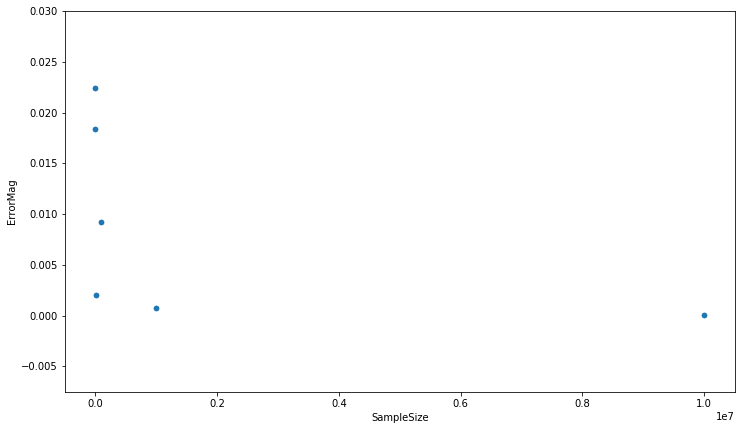

In [12]:
df_all.plot.scatter(x='SampleSize',y='ErrorMag',figsize=(12,7))

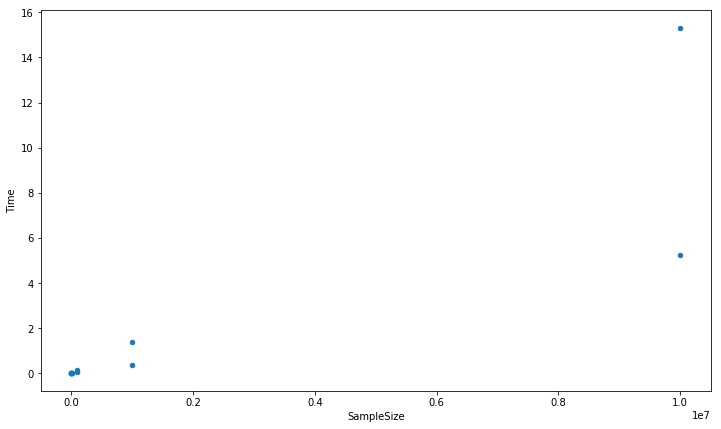

In [13]:
df_all.plot.scatter(x='SampleSize',y='Time',figsize=(12,7))

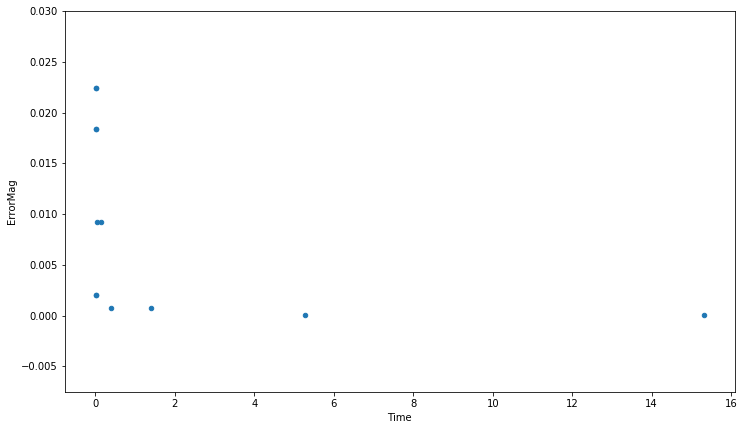

In [14]:
df_all.plot.scatter(x='Time',y='ErrorMag',figsize=(12,7))